# Board Game Reccomendation Using Game Description and Game Classification

In [58]:
from IPython.display import Image
import urllib2, time, random, re
from bs4 import BeautifulSoup, SoupStrainer
import pandas as pd
import requests
import pickle
import nltk
from sklearn.metrics.pairwise import cosine_similarity
import re
import numpy as np
from fuzzywuzzy import process, fuzz
from sklearn.metrics.pairwise import pairwise_distances
import time
import sys
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer, PorterStemmer
sys.setrecursionlimit(10000000)


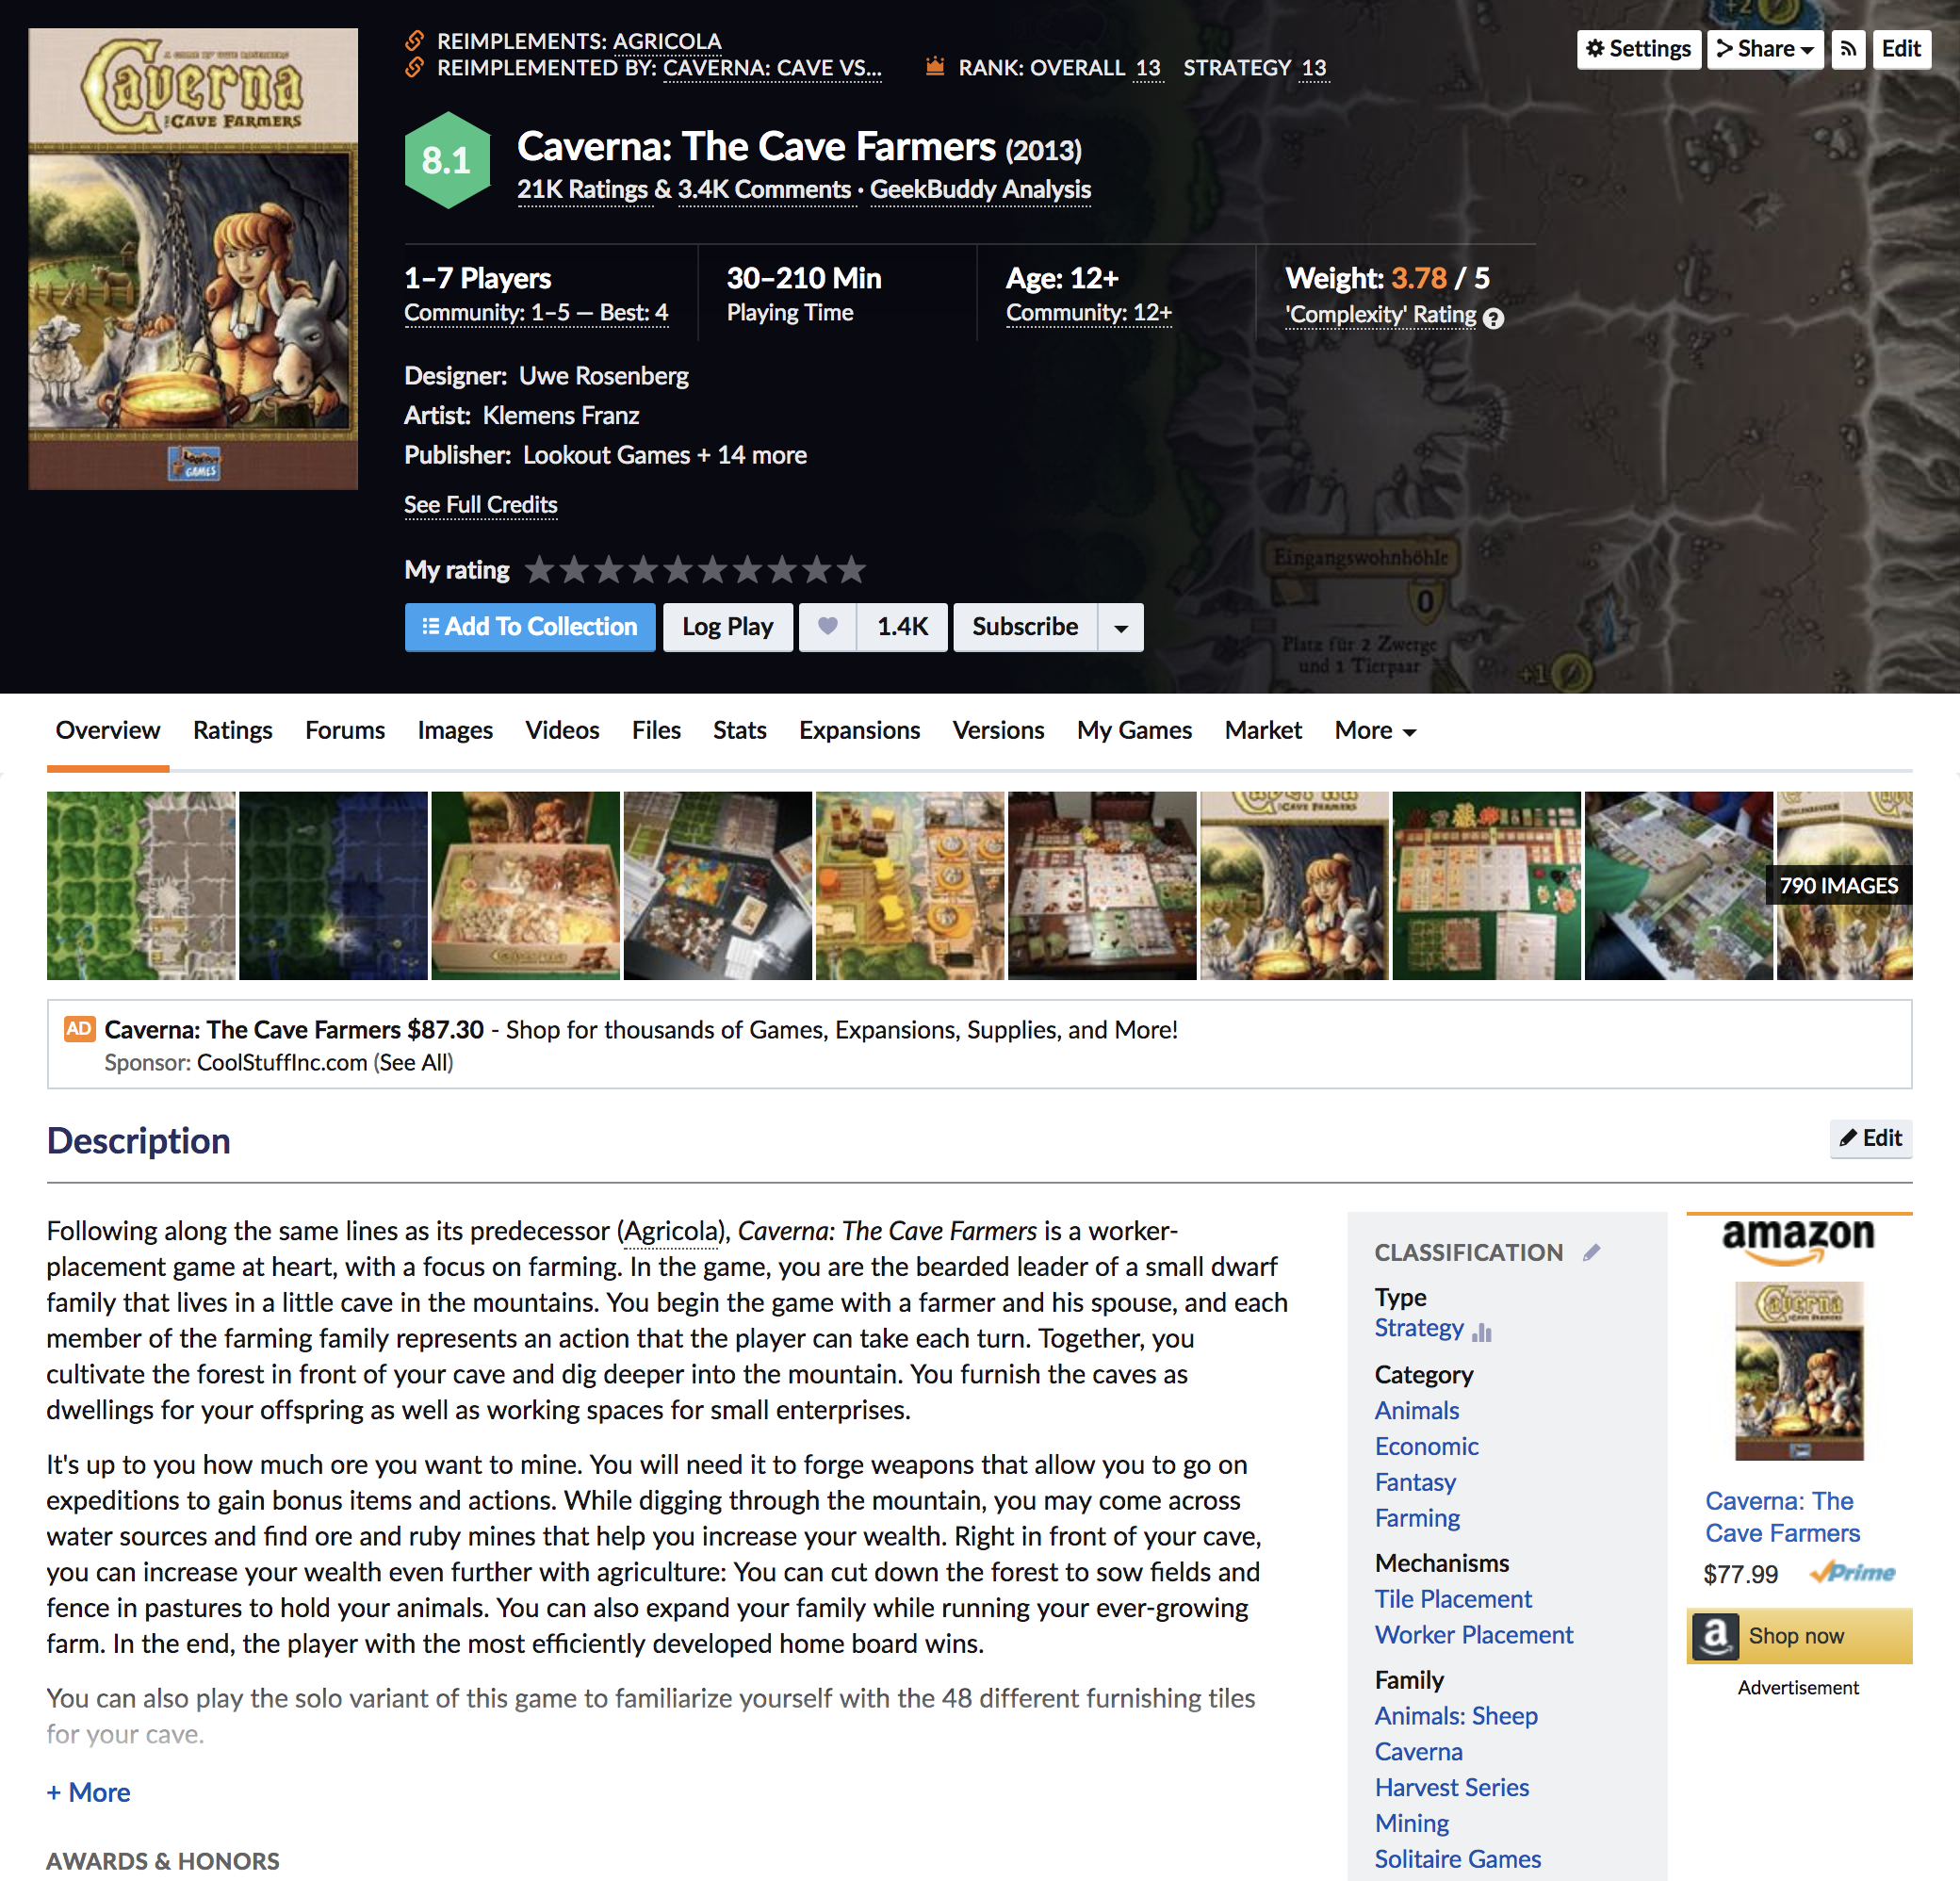

In [59]:
Image(filename='bgg_example.png')

# Collecting All Ranked Board Games on Board Game Geeks Website

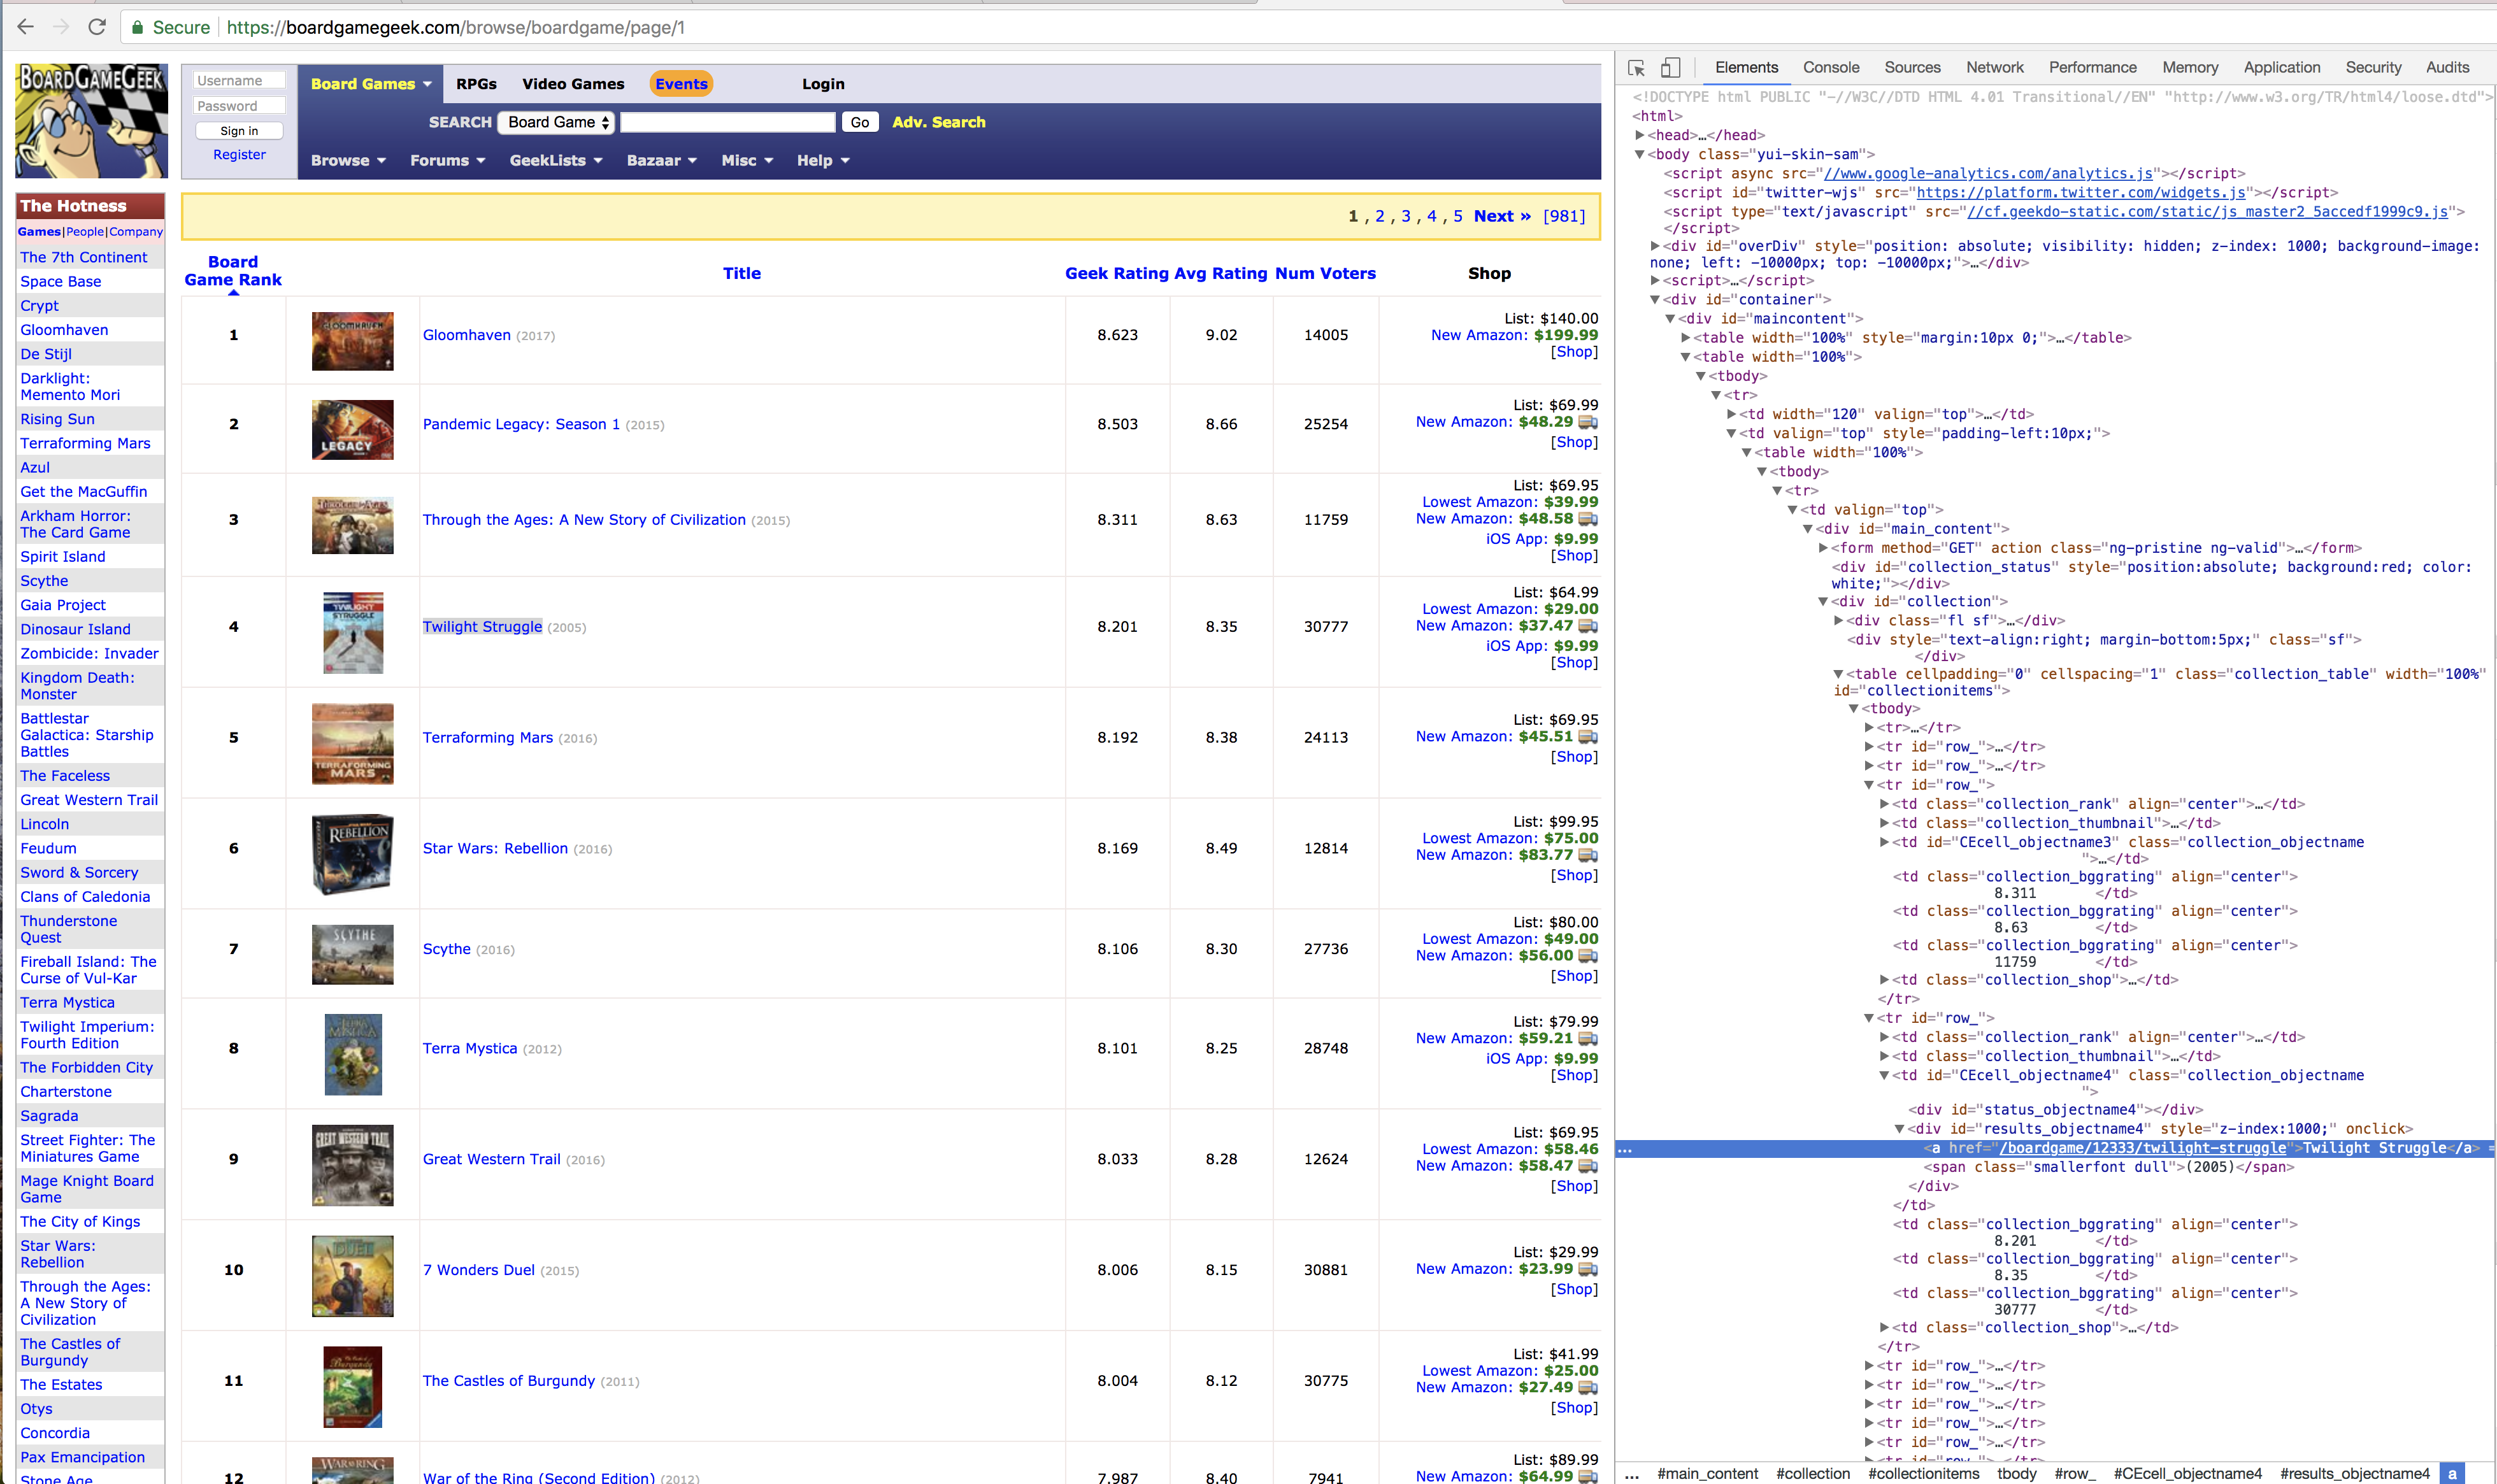

In [61]:
Image(filename='bgg_collect_games.png')

In [23]:
#find all the links given website and append to all_url list. 
#From that list find all the links that end with /boardgame/somedigits
soup = BeautifulSoup(urllib2.urlopen(urllib2.Request("https://boardgamegeek.com/browse/boardgame")).read())
all_url = []
for i in range(1,11):
    soup = BeautifulSoup(urllib2.urlopen(urllib2.Request("https://boardgamegeek.com/browse/boardgame/page/" + str(i))).read())
    for a in soup.find_all('a', href = True):
        all_url.append(a['href'])
board_games = []
for url in all_url:
    if re.match('/boardgame/\d+\w+', url):
        board_games.append(url)

In [24]:
#get the board game ID numbers
board_games_nums =[]
for b in board_games:
    d = re.search('\d+', b)
    board_games_nums.append(d.group(0))

# Collect Game Description, Publisher, Play Mechanism, and Game Category

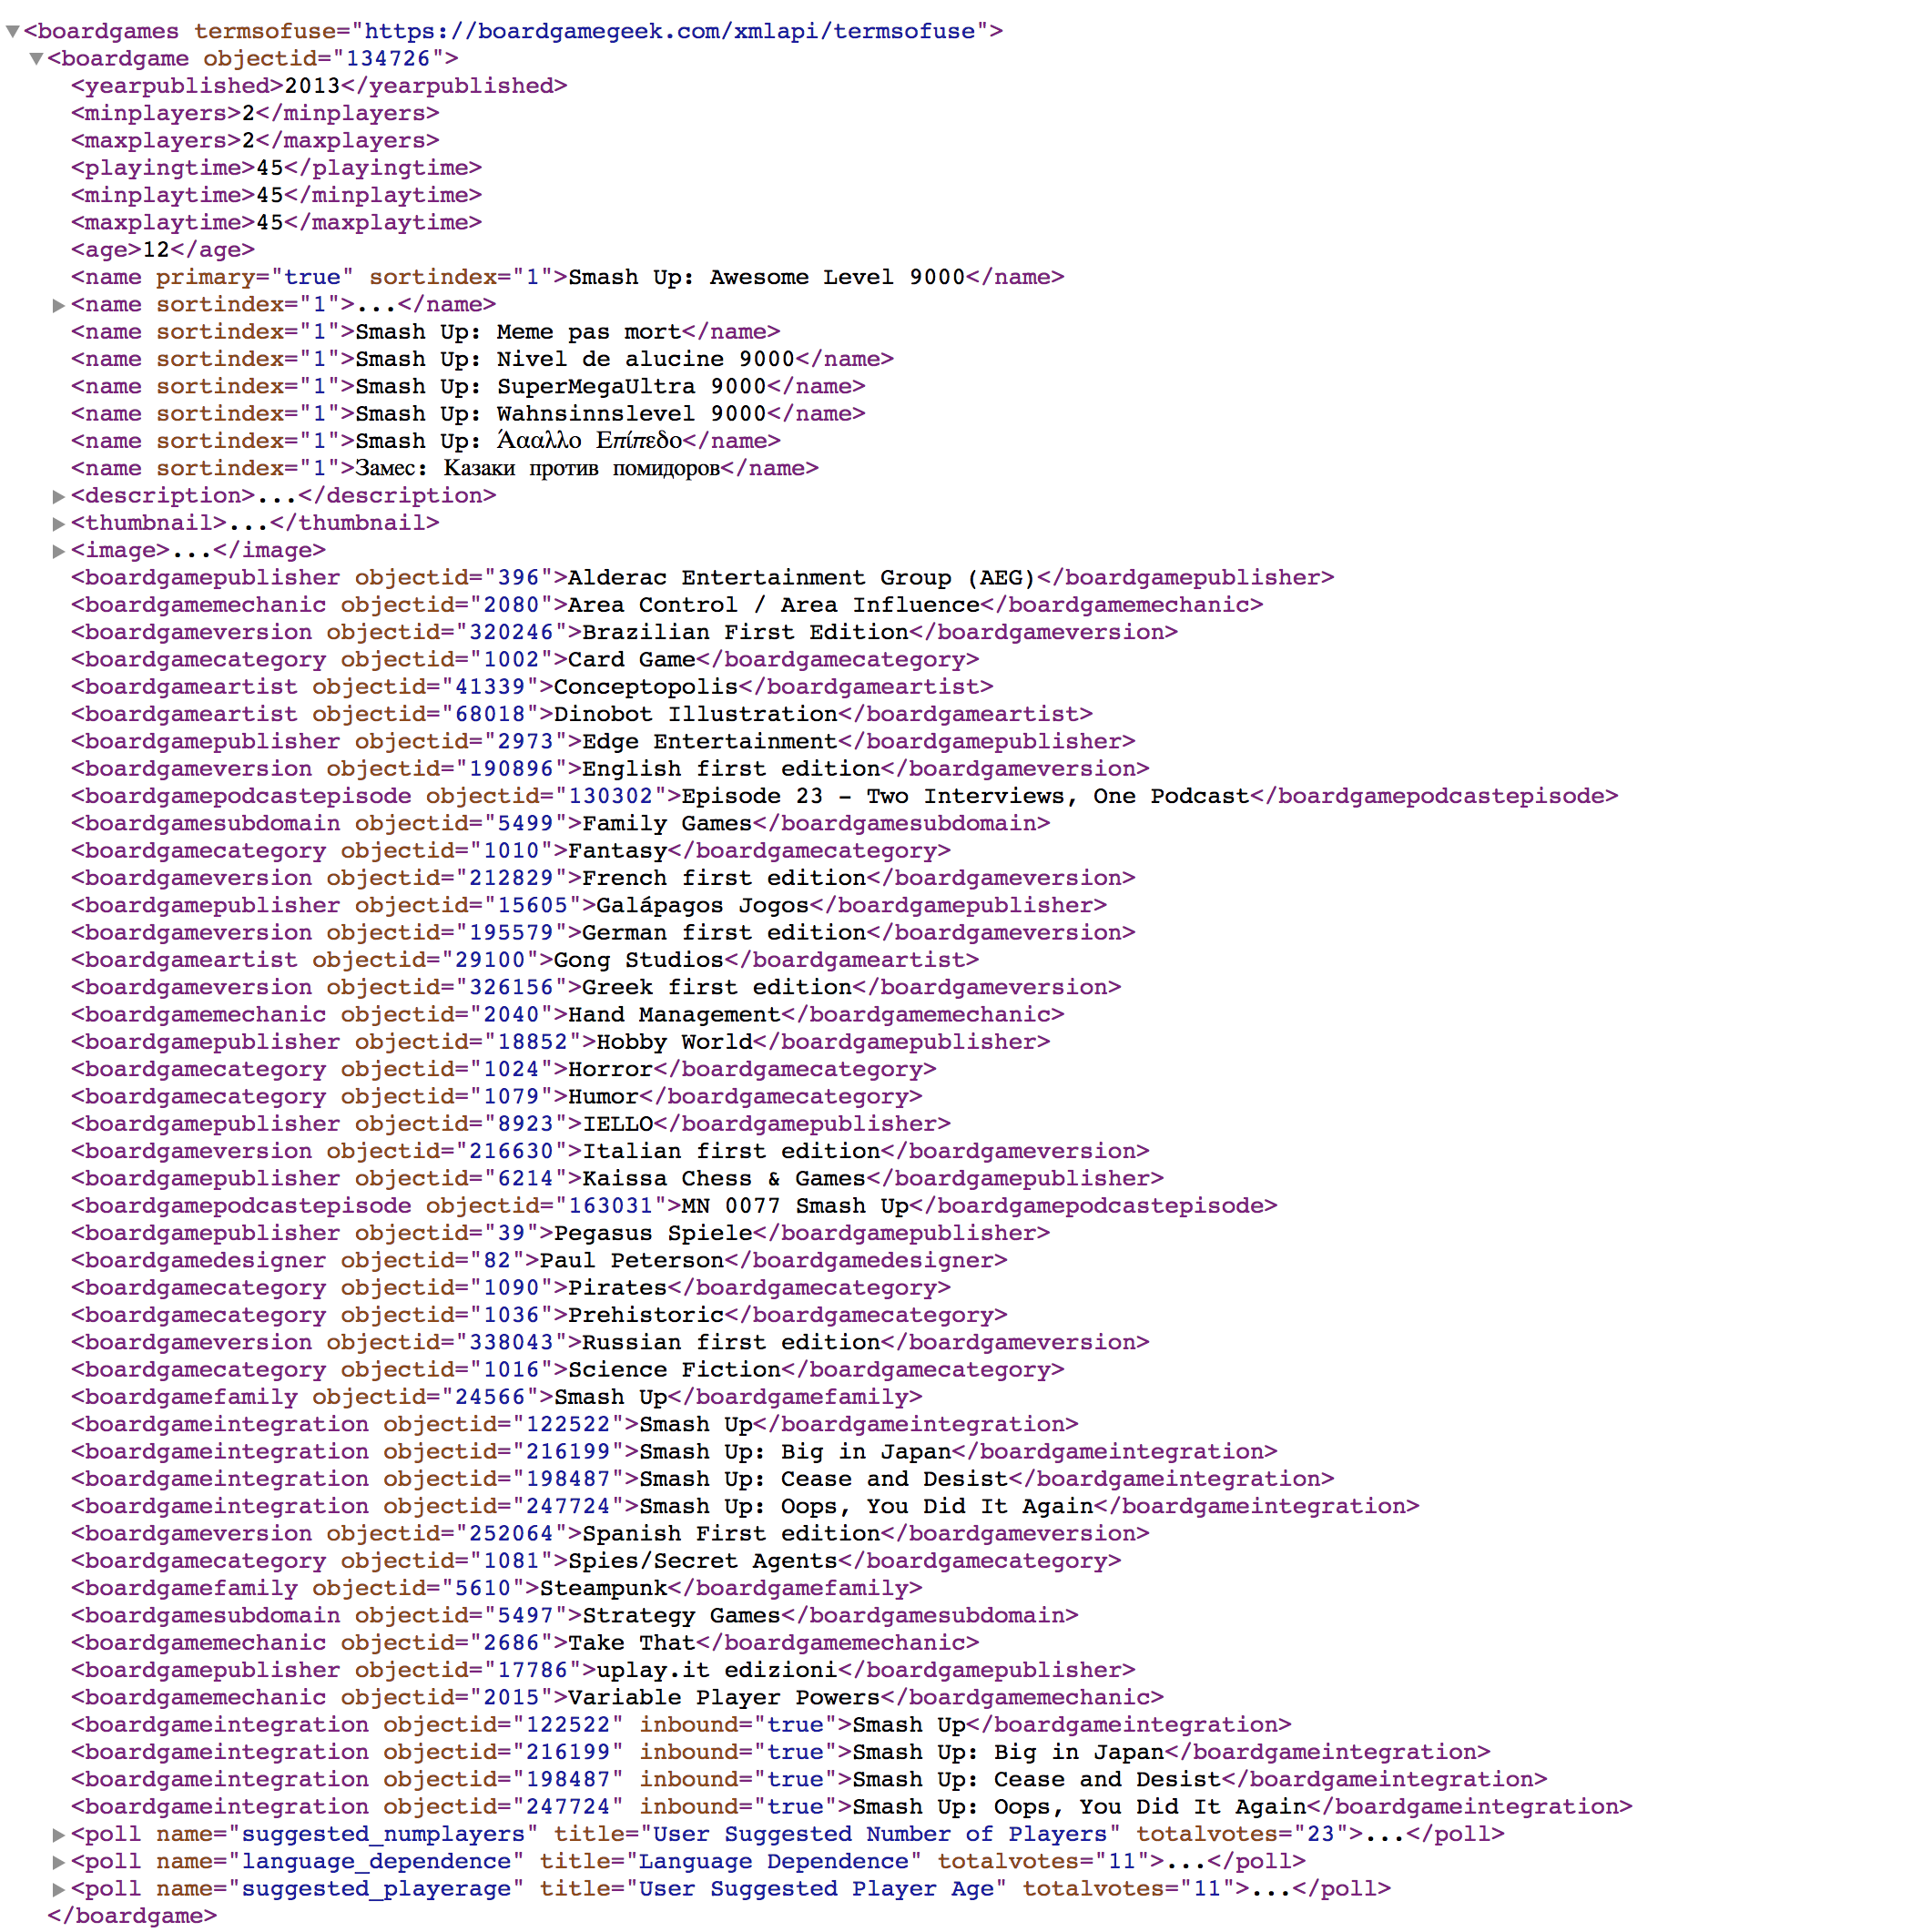

In [62]:
Image(filename='bgg_api_png.png')

In [70]:
#find the descriptions of all the games and add to dictionary
start_time = time.time()
games = list(set(board_games_nums))
dic ={}
while len(games)>0:
    s = ','.join(games[:25])
    final_url = 'http://www.boardgamegeek.com/xmlapi/boardgame/' + s
    soup = BeautifulSoup(urllib2.urlopen(urllib2.Request(final_url)).read())
    for num in games[:25]:
        name_of_game = soup.find('boardgame', {'objectid': num}).find('name', {'primary' : 'true'}).text
        des = soup.find('boardgame', {'objectid': num}).description.text
        dic[name_of_game] = {}
        dic[name_of_game]['description'] = des
        mech = soup.find('boardgame', {'objectid': num}).find_all('boardgamemechanic', text = True)
        m = [t.text for t in mech]
        publish = soup.find('boardgame', {'objectid': num}).find_all('boardgamepublisher', text = True)
        p = [t.text for t in publish]
        cat = soup.find('boardgame', {'objectid': num}).find_all('boardgamecategory', text = True)
        c = [t.text for t in cat]
        total = m + p + c
        dic[name_of_game]['classification'] = total
    games = games[25:]
print("--- %s seconds ---" % (time.time() - start_time))

--- 306.618353128 seconds ---


In [84]:
dic['Caverna: The Cave Farmers']['classification']

[u'Tile Placement',
 u'Worker Placement',
 u'Lookout Games',
 u'999 Games',
 u'Crowd Games',
 u'Devir',
 u'Filosofia \xc9ditions',
 u'Gemenot',
 u'Hobby Japan',
 u'HomoLudicus',
 u'Korea Boardgames co., Ltd.',
 u'Lacerta',
 u'Ludofy Creative',
 u'Mayfair Games',
 u'MINDOK',
 u'Swan Panasia Co., Ltd.',
 u'uplay.it edizioni',
 u'Animals',
 u'Economic',
 u'Fantasy',
 u'Farming']

In [85]:
dic['Caverna: The Cave Farmers']['description']

u"Following along the same lines as its predecessor (Agricola), Caverna: The Cave Farmers is a worker-placement game at heart, with a focus on farming. In the game, you are the bearded leader of a small dwarf family that lives in a little cave in the mountains. You begin the game with a farmer and his spouse, and each member of the farming family represents an action that the player can take each turn. Together, you cultivate the forest in front of your cave and dig deeper into the mountain. You furnish the caves as dwellings for your offspring as well as working spaces for small enterprises.<br/><br/>It's up to you how much ore you want to mine. You will need it to forge weapons that allow you to go on expeditions to gain bonus items and actions. While digging through the mountain, you may come across water sources and find ore and ruby mines that help you increase your wealth. Right in front of your cave, you can increase your wealth even further with agriculture: You can cut down th

## Pickling Dictionary

In [86]:
#saving the dictionary 
pickle_out = open('dic_of_game_desp', 'wb')
pickle.dump(dic, pickle_out)
pickle_out.close()

In [87]:
#loading the dictionary
pickle_in = open('dic_of_game_desp', 'rb')
dic = pickle.load(pickle_in)

# Word Tokenization and Word Preprocessing using Stemming and Lemmatization 

# Stemming VS Lemmatization

In [93]:
example = ['double', 'doubling', 'doubles', 'doubled']
lemmatizer = WordNetLemmatizer()
ps = PorterStemmer()
lemmatizer_example = [lemmatizer.lemmatize(w) for w in example]
stemming_example = [ps.stem(w) for w in example]
example_df = pd.DataFrame(np.column_stack([example, lemmatizer_example, stemming_example]), 
                               columns=['original', 'lemmatization', 'stemming'])
example_df

original lemmatization stemming
0    double        double    doubl
1  doubling      doubling    doubl
2   doubles        double    doubl
3   doubled       doubled    doubl

## Word Tokenize and Preprocess Game Description

In [31]:
tokenize ={}
tokenize_lem = {}
tokenize_stem = {}
stop_words = stopwords.words('english')
stop_words.append('br')
stop_words = set(stop_words)
tokenizer = RegexpTokenizer(r'\w+')
lemmatizer = WordNetLemmatizer()
ps = PorterStemmer()
for game in dic.keys():
    des = tokenizer.tokenize(dic[game]['description'])
    lower_des = [d.lower() for d in des]
    filtered_des = [w for w in lower_des if not w in stop_words]
    lem_des = [lemmatizer.lemmatize(w) for w in filtered_des]
    stem_des = [ps.stem(w) for w in filtered_des]
    tokenize_lem[game] = nltk.FreqDist(lem_des)
    tokenize[game]= nltk.FreqDist(filtered_des)
    tokenize_stem[game] = nltk.FreqDist(stem_des)

In [32]:
#change tokenize words to Dataframe
tokenize_df = pd.DataFrame.from_dict(tokenize, orient = 'index').fillna(0)
tokenize_stem_df = pd.DataFrame.from_dict(tokenize_stem, orient = 'index').fillna(0)
tokenize_lem_df = pd.DataFrame.from_dict(tokenize_lem, orient = 'index').fillna(0)

## Calculation of TF-IDF

The importance of a word is weighted based on the frequency the word appears in the document. However if a particular word was also found frequently in all other documents, perhaps this word is not as important as unique word in that document that is mentioned less frequently. 

### For Example:
We have 3 sentences:

1. The blue cow is the cow that jumped over the fence
2. The green cow is the cow that likes to roll in the mud
3. The red cow is the cow that ate the boy's food

When the sentenencs are tokenized with stop words removed we have:
1. [blue, cow, cow, jumped, over, fence]
2. [green, cow, cow, likes, roll, mud]
3. [red, cow, cow, ate, boy's, food]

When looking individually at the setences it seems as if cow may be a very important word in the sentence. However since cow is mentioned frequently in all the sentences the word cow holds less weight than a word that is unique to that sentence. 

Formula to calculate TF-IDF:  
TF(t) = (Number of times term t appears in a document) / (Total number of terms in the document).  
IDF(t) = log(Total number of documents / Number of documents with term t in it).  
TF-IDF = TF(t) X IDF(t)  

In [95]:
def term_freq(df):
    df.loc[:,:]= df.loc[:,:].div(df.sum(axis=1), axis = 0)
    return(df)

In [34]:
def IDF(df):
    num_doc_with_word = df.astype(bool).sum(axis=0)
    num_games = len(df.index)
    idf = np.log(num_games / (1 + df.astype(bool).sum(axis=0)))
    return(idf)

In [35]:
def tf_idf(tf_df, idf):
    df = tf_df.multiply(idf, axis =1)
    return(df)

In [36]:
t = term_freq(tokenize_df)
idf_t = IDF(t)
t_dif = tf_idf(t, idf_t.values)

In [37]:
ts = term_freq(tokenize_stem_df)
idf_t_s = IDF(ts)
t_dif_s = tf_idf(ts, idf_t_s.values)

In [38]:
tl = term_freq(tokenize_lem_df)
idf_t_l = IDF(tl)
t_dif_l = tf_idf(tl, idf_t_l.values)

## Recommendation Algorithm Based on Cosine Similiarity

In [96]:
def recommend(game, df):
    cos = cosine_similarity(df)
    game_names = [c.lower() for c in df.index.values]
    cos_df = pd.DataFrame(cos, index = game_names, columns = game_names)
    g_extract = process.extractOne(str(game).lower() , game_names)
    if fuzz.partial_ratio(str(game), g_extract[0]) < 75:
        print ('This game is not in the top 1000 games in BGG, did you mean ' + g_extract[0])
    else:
        top = cos_df.loc[:,g_extract[0]].sort_values(ascending = False)[1:11].index.values
        print'Top 10 matches for ', g_extract[0]
        for c, value in enumerate(top, 1):
            print c, value
        return(top)

In [98]:
no_process = recommend('caverna the cave farmers', df = t_dif)

Top 10 matches for  caverna: the cave farmers
1 vast: the crystal caverns
2 caverna: cave vs cave
3 summoner wars: guild dwarves vs cave goblins
4 agricola: all creatures big and small
5 agricola (revised edition)
6 agricola
7 ora et labora
8 forge war
9 above and below
10 dungeons & dragons: wrath of ashardalon board game


In [97]:
stem = recommend('caverna the cave farmers', df = t_dif_s)

Top 10 matches for  caverna: the cave farmers
1 caverna: cave vs cave
2 vast: the crystal caverns
3 agricola: all creatures big and small
4 agricola (revised edition)
5 summoner wars: guild dwarves vs cave goblins
6 agricola
7 dream home
8 ora et labora
9 forge war
10 oregon


In [99]:
lem = recommend('caverna the cave farmers', df = t_dif_l)

Top 10 matches for  caverna: the cave farmers
1 vast: the crystal caverns
2 caverna: cave vs cave
3 agricola: all creatures big and small
4 summoner wars: guild dwarves vs cave goblins
5 agricola (revised edition)
6 agricola
7 ora et labora
8 forge war
9 la isla
10 above and below


In [105]:
set(no_process).intersection(stem).intersection(lem)

{u'agricola',
 u'agricola (revised edition)',
 u'agricola: all creatures big and small',
 u'caverna: cave vs cave',
 u'forge war',
 u'ora et labora',
 u'summoner wars: guild dwarves vs cave goblins',
 u'vast: the crystal caverns'}

In [39]:
game_mech ={}
for game in dic.keys():
    #mech = tokenizer.tokenize(dic[game]['mechanism'])
    lower_mech = [m.lower() for m in dic2[game]['classification']]
    game_mech[game] = nltk.FreqDist(lower_mech)

In [40]:
mech_df = pd.DataFrame.from_dict(game_mech, orient = 'index').fillna(0)

In [48]:
def reccomend_jac(game, df):
    game_names = [c.lower() for c in df.index.values]
    g_extract = process.extractOne(str(game).lower() , game_names)
    if fuzz.partial_ratio(str(game), g_extract[0]) < 75:
        print ('This game is not in the top 1000 games in BGG, did you mean ' + g_extract[0])
    else:    
        jac_sim = 1 - pairwise_distances(df, metric = "hamming")
        jac_sim = pd.DataFrame(jac_sim, columns = game_names, index = game_names)
        top_10 = jac_sim.loc[g_extract[0]].sort_values(ascending = False)[1:11].index.values
        print 'Top 10 matches for ' , str(g_extract[0])
        for c, value in enumerate(top_10, 1):
            print c, value
reccomend_jac('caverna', df = mech_df)

Top 10 matches for  caverna: cave vs cave
1 caverna: the cave farmers
2 walnut grove
3 bärenpark
4 murano
5 viticulture
6 agricola: all creatures big and small
7 brew crafters
8 merkator
9 automania
10 diamonds club
